# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [133]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
#helping module to render matplotlib plots in IPython dark theme correctly
from jupyterthemes import jtplot
jtplot.style()
# Import supplementary visualizations code visuals.py
import visuals as vs
import seaborn as sns
# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [135]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


From the statistical describtion above:

- the mean is considerably larger than the median (50% procentile) therefore we need to watch out for the ourliers, that "drag" the mean to the right side of the distribution.

- the standard deviation is large that suggests our data points are far from the mean, which indicates the data must be scewed to right. 


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [136]:
# TODO: Select three indices of your choice you wish to sample from the dataset 
indices = [43, 131, 427]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,630,11095,23998,787,9529,72
1,2101,589,314,346,70,310
2,31012,16687,5429,15082,439,1163


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?

**Hint:** Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant. You can use the mean values for reference to compare your samples with. The mean values are as follows:

* Fresh: 12000.2977
* Milk: 5796.2
* Grocery: 7951.3
* Detergents_paper: 2881.4
* Delicatessen: 1524.8

Knowing this, how do your samples compare? Does that help in driving your insight into what kind of establishments they might be? 


**Answer:**

`data[43]` datapoint is a customer with considerable purchase costs on Milk, Grocery and Detergents categories, which are main items in cafe/restaurants expenditures. 

`data[131]` datapoint is distinct by its small total costs across all product categories, so we may assume this customer might be just a household or some extremely small street-food vendor.

`data[427]` datapoint is distinct by large expenditures across all the product categories, look like it is osme kind of a retailer. 

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [137]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop(['Grocery'], axis = 1)

# TODO: Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
X_train, X_test, y_train, y_test = train_test_split(new_data, 
                                    data[['Grocery']], 
                                    test_size = 0.25, 
                                    random_state = 42)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [138]:
score

0.7498079784650057

In [139]:
#Let's check which features made most of the contribution for our RandomForestRegressor, to do that we check out feature_importances_ array
for feature, importance in zip(list(X_train.columns), list(regressor.feature_importances_)):
    print("Feature %s : %.2f " %(feature, importance))

Feature Fresh : 0.02 
Feature Milk : 0.07 
Feature Frozen : 0.02 
Feature Detergents_Paper : 0.88 
Feature Delicatessen : 0.02 


Looks like `Detergents` was the most important feature for our `RandomForestRegressor`, since it has the highest importance score. It will not be surprising if `Grocery` and `Detergents` cprrelate with each other.

### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data. If you get a low score for a particular feature, that lends us to beleive that that feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

**Answer:**

We tried to predict the amount of grocery products bought by customers depending on the amount of products of other categories they bought. 
Our RandomForestRegressor achieved 0.74 R^2 score, which means the grocery category is quite easy to predict with other product categories.

The high R^2 score means most of the variance of the Grocery product category could be explained by other features, so this feature will not give us a lot of new information for our analysis of customers' spending habits.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

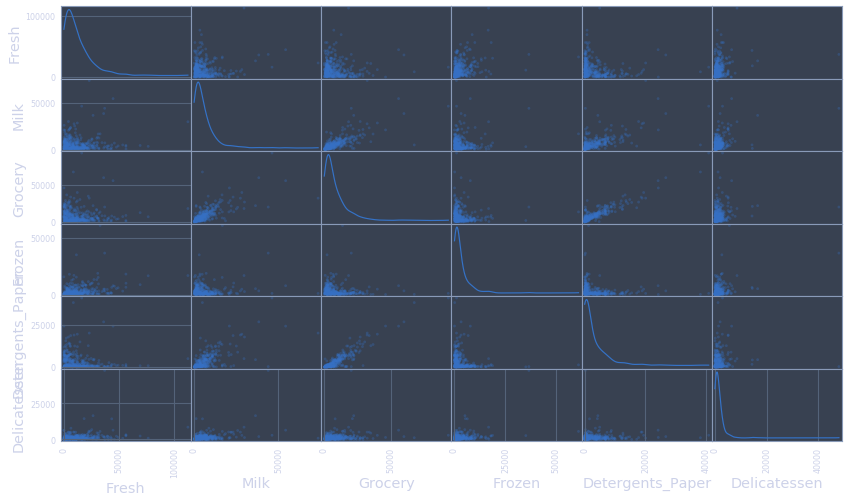

In [140]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

**Hint:** Is the data normally distributed? Where do most of the data points lie? You can use [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to get the feature correlations and then visualize them using a [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html)(the data that would be fed into the heatmap would be the correlation values, for eg: `data.corr()`) to gain further insight.

**Answer:**

Just as we noticed from descriptive statistic, the distribution of the data for all product categories is not normal and is scewed to the right, with several outliers with extremely large values being present in every product category, while most of the datapoints are consentrated to the left of the distribution. 

From our visual inspection we notice some positive correlation between several features: `Grocery` and `Detergents`, `Grocery` and `Milk`, `Milk` and `Detergents`. With the increase of value in one feature, the other one increases too. 
Positive correlation between `Detergents` and `Grocery` product categories could explain high feature importance score for `Detergents` feature in our RandomForestRegressor predictions. 

Let's get more quantitative estimate by using pandas `corr()` module and `seaborn heatmap`

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


None


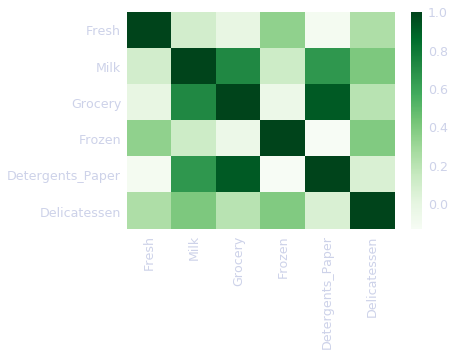

In [141]:
print(display(data.corr()))

corr= data.corr()

#we can also build a quick heatmap to visualize our correlation matrix 
sns.heatmap(data.corr(), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            cmap = 'Greens')

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


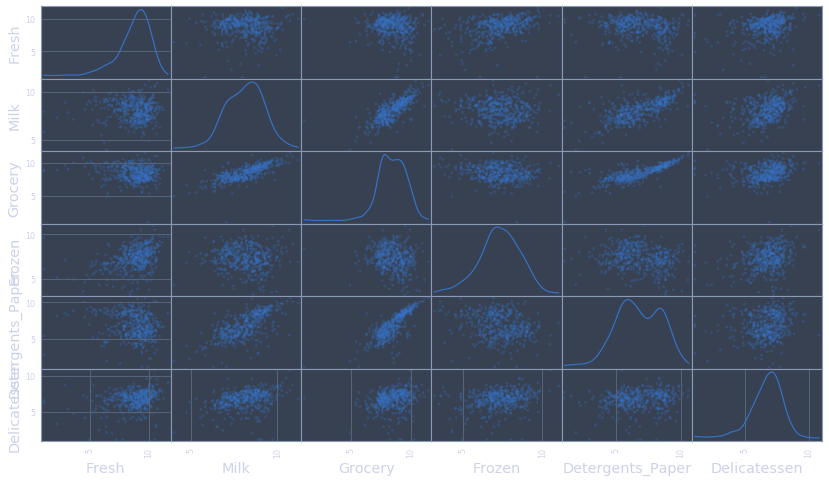

In [142]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [143]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6.445720,9.314250,10.085726,6.668228,9.162095,4.276666
1,7.650169,6.378426,5.749393,5.846439,4.248495,5.736572
2,10.342130,9.722385,8.599510,9.621257,6.084499,7.058758


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [144]:
# see the shape pf our original dataset 
data.shape

(440, 6)

In [145]:
# initializing set to capture all outlier indices only once

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    print('min threshold', Q1-step)
    print('max threshold', Q3 + step)
    display(log_data[feature].describe())

# convert set to list
outliers = [ 95, 96, 128,218,338,353,357,412, 38, 57, 420,429,145,75,161,109,142,184,187,233,285, 203]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


min threshold 5.514550833608026
max threshold 12.270571816559475


count    440.000000
mean       8.730544
std        1.480071
min        1.098612
25%        8.048059
50%        9.048286
75%        9.737064
max       11.627601
Name: Fresh, dtype: float64

Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


min threshold 5.016732967223546
max threshold 11.198728361406147


count    440.000000
mean       8.121047
std        1.081365
min        4.007333
25%        7.334981
50%        8.196159
75%        8.880480
max       11.205013
Name: Milk, dtype: float64

Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


min threshold 5.275759987575941
max threshold 11.67270989103498


count    440.000000
mean       8.441169
std        1.116172
min        1.098612
25%        7.674616
50%        8.467057
75%        9.273854
max       11.437986
Name: Grocery, dtype: float64

Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


min threshold 4.260350248162942
max threshold 10.525223584187506


count    440.000000
mean       7.301396
std        1.284540
min        3.218876
25%        6.609678
50%        7.330388
75%        8.175896
max       11.016479
Name: Frozen, dtype: float64

Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


min threshold 1.4587426638529726
max threshold 12.363699359688528


count    440.000000
mean       6.785972
std        1.721020
min        1.098612
25%        5.548101
50%        6.705018
75%        8.274341
max       10.617099
Name: Detergents_Paper, dtype: float64

Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


min threshold 3.7695940025105954
max threshold 9.7490090809691


count    440.000000
mean       6.665133
std        1.310832
min        1.098612
25%        6.011875
50%        6.872645
75%        7.506728
max       10.777768
Name: Delicatessen, dtype: float64

In [146]:
# let's check out the shape of the dataframe after removing the outliers
good_data.shape

(418, 6)

We removed 22 datapoints from our dataset as outliers 

### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

** Hint: ** If you have datapoints that are outliers in multiple categories think about why that may be and if they warrant removal. Also note how k-means is affected by outliers and whether or not this plays a factor in your analysis of whether or not to remove them.

**Answer:**

There are four data points that are calculated as an outliers for two features and one point that considered as an ourlier for three features. 

`data[65]` - outlier for 'Fresh' and 'Frozen'

`data[75]` - outlier for 'Grocery' and 'Detergents'

`data[154]` - outlier for 'Delicatessen', 'Milk, and 'Grocery'

`data[128]` - outlier for 'Fresh' and 'Delicatessen'

`data[66]` - outlier for 'Fresh' and 'Delicate'

These points should not be removed, since they appear in more than one feature, so clearly they contain some trend and should be considered during clustering. 

Our dataset is not so big, so we need to be careful with removing any information from there and therefore we might decide to keep some points defined as outliers using Tukey's method if they lay reasonably close to the [Q1-step, Q3+step] thresholds.


## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

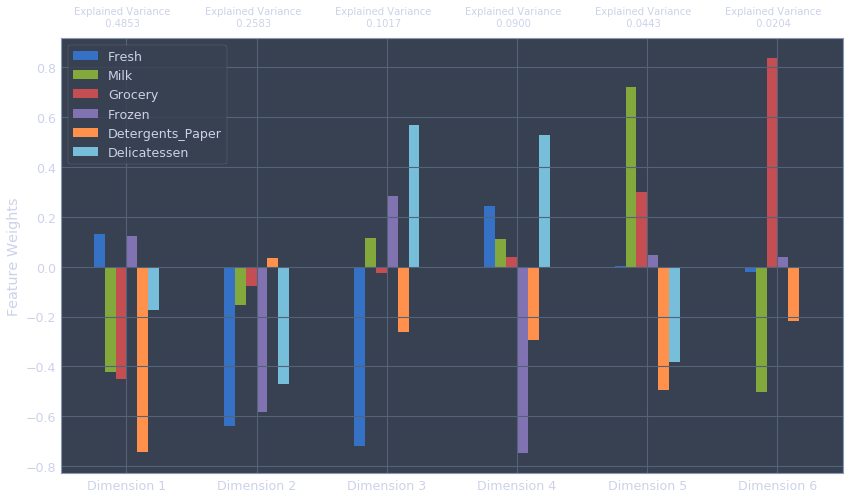

In [147]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components = good_data.shape[1])
pca.fit(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

In [148]:
#let's pull out the array of explained varaince ratios from our fitted pca object
pca.explained_variance_ratio_

array([0.4852895 , 0.25832722, 0.10173868, 0.08998366, 0.04426185,
       0.02039909])

**Answer:**

1. The first and second princial components explain about 74% of the variance in our data

2. The first principal component explains roughly 49% of the variance of the data, second - 26%, third - 10%, fourth - 9% of variance in data

3.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [149]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.9750,2.8855,-0.4042,-1.8617,1.0994,0.3139
1,3.6820,2.5194,0.3828,0.7663,-0.4866,-0.8405
2,0.2053,-2.6923,0.0966,-0.7563,1.5439,-0.4560


In [150]:
# let's print out our log transformed samples to be able to compare
log_samples

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6.445720,9.314250,10.085726,6.668228,9.162095,4.276666
1,7.650169,6.378426,5.749393,5.846439,4.248495,5.736572
2,10.342130,9.722385,8.599510,9.621257,6.084499,7.058758


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [151]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components= 2)
pca.fit(good_data)
# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [152]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.9750,2.8855
1,3.6820,2.5194
2,0.2053,-2.6923


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

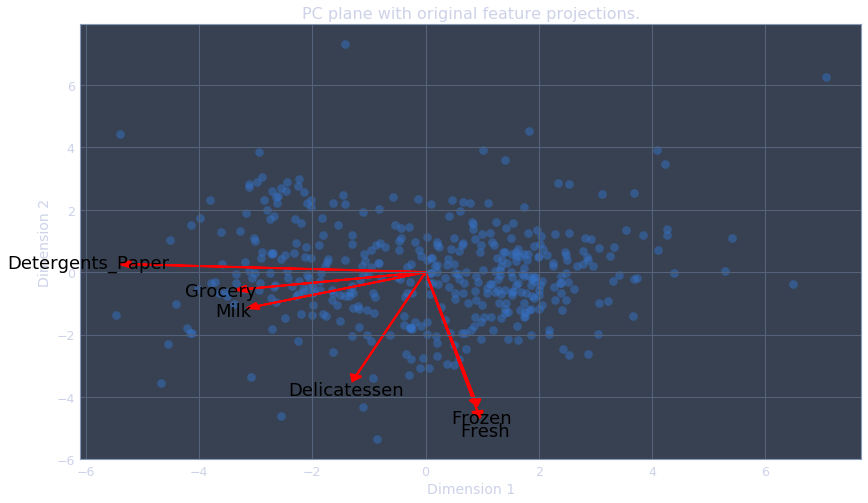

In [153]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

**Answer:**
The main advantages of using K-means clustering are : 

1) Fast training (all we need to do is calculate the distance between the points), however for big dataset this alorithm might rove to be not efficiebt as it's complexity linearly increases as the dataset getting larger

2) Simple and intuitive, due to it's simplicity it is very easy to debug or tune K-Means clustering model 
K-Means is a hard clustering algorithm, i.e. each point can belong to one cluster, also K_means are quite sensitive to the outliers. 

The main advantages of GMM are:

1) Cluster shape flexibility: while k-means can produce only spherical clusters, with the radius being the most distant point in the cluster, GMM is a lot more flexible in terms of cluster covariance, which means it can produce oblong eliptical clusters capturing the elongated distributions on the data points much better than k-means [2]

2) Soft clustering, instead of flagging each point to belong to a certain cluster, GMM calculates the probability tha a given point belongs to a given cluster, in other words in GMM each point belong to each cluster to a different degree [1]. 

Since Gaussian Mixture models are more flexible we can try to apply this algorithm to our data, experimenting with number of clusters and convariance types (GMM with 'spherical' `covarinace_type` is essentially K-Means algorithm, so we will have chance try k-means to this data too) 

1. https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

2. https://www.quora.com/What-are-the-advantages-to-using-a-Gaussian-Mixture-Model-clustering-algorithm  


### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [161]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
results = {}
for k in ['full', 'spherical', 'diag','tied']:
    results[k] = {}
    print('COVARIANCE TYPE:', k )
    for i in range(2,7):
        results[k][i] = {}
        # TODO: Apply your clustering algorithm of choice to the reduced data 
        clusterer = GaussianMixture(n_components = i, covariance_type= k)
        clusterer.fit(reduced_data)
        
        # TODO: Predict the cluster for each data point
        preds = clusterer.predict(reduced_data)
        results[k][i]['preds'] = np.asarray(preds)
        # TODO: Find the cluster centers
        centers = clusterer.means_
        results[k][i]['centers'] = np.asarray(centers)
        # TODO: Predict the cluster for each transformed sample data point
        sample_preds = clusterer.predict(pca_samples)
        results[k][i]['sample_preds'] = sample_preds
        # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
        score = silhouette_score(reduced_data, preds)
        print('With %d clusters, the silhoutte score is %0.3f'%(i, score))

COVARIANCE TYPE: full
With 2 clusters, the silhoutte score is 0.430
With 3 clusters, the silhoutte score is 0.326
With 4 clusters, the silhoutte score is 0.253
With 5 clusters, the silhoutte score is 0.261
With 6 clusters, the silhoutte score is 0.337
COVARIANCE TYPE: spherical
With 2 clusters, the silhoutte score is 0.435
With 3 clusters, the silhoutte score is 0.374
With 4 clusters, the silhoutte score is 0.341
With 5 clusters, the silhoutte score is 0.358
With 6 clusters, the silhoutte score is 0.288
COVARIANCE TYPE: diag
With 2 clusters, the silhoutte score is 0.429
With 3 clusters, the silhoutte score is 0.354
With 4 clusters, the silhoutte score is 0.337
With 5 clusters, the silhoutte score is 0.308
With 6 clusters, the silhoutte score is 0.352
COVARIANCE TYPE: tied
With 2 clusters, the silhoutte score is 0.426
With 3 clusters, the silhoutte score is 0.301
With 4 clusters, the silhoutte score is 0.311
With 5 clusters, the silhoutte score is 0.302
With 6 clusters, the silhoutte sc

### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer:**

We tried 20 different combinations of `covariance_type` and `n_components` and the best silhoutte score was produced by GM model with spherical covariance type (which is actually K-means) with 2 components

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

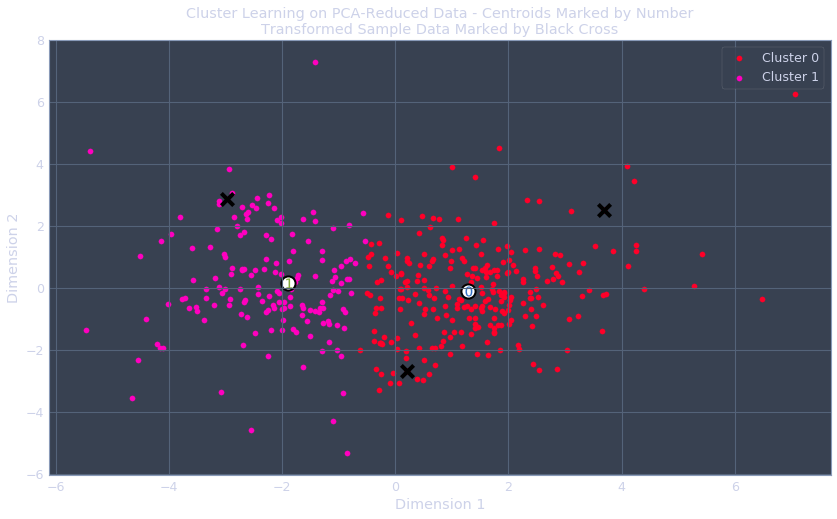

In [167]:
centers = results['spherical'][2]['centers']
preds = results['spherical'][2]['preds']

# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [168]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8819.0,1992.0,2593.0,2009.0,343.0,724.0
Segment 1,4850.0,7354.0,10701.0,1145.0,3717.0,1106.0


### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. Think about what each segment represents in terms their values for the feature points chosen. Reference these values with the mean values to get some perspective into what kind of establishment they represent.

In [169]:
#Let's review statistical description of the data again
display(data.describe())       

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


**Answer:**

As we see the total purchase costs of almost each category for the points derived are considerably lower than the averages in general statistics of the initial data. I think this is because the initial data contain outliers, while we perfomed clustering on clean data, with most of the outliers removed. 

Cluster 0 represents a customer who spends mostly on Detergents as well as Milk and Grocery (all three of these categories are well above the general mean derived from data), this customer may represent some hotels (?) or maybe retailers. 

Cluster 1 represent a customer who spends mostly on Fresh products and very less on other product categories, this might be a cafe or restaurant. 


### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [166]:
print(display(samples))
# Display the predictions
sample_preds = results['spherical'][2]['sample_preds']
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,630,11095,23998,787,9529,72
1,2101,589,314,346,70,310
2,31012,16687,5429,15082,439,1163


None
Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 0


**Answer:**

The first point perfectly fits Cluster 1, since the products categories with major expenditures are Detergents, Milk and Grocery

The second and third point obviously belong to Cluster 0, since its main product category of expenditures is Fresh.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

I think changing the delivery from 5 to 3 days a week will affect mostly the customer that spend on Fresh products mostly because of the short expiry time of such products, while customers from Cluster 0 can buy more products than they need and keep some products at storage (Milk and Grocery), fresh products cannot be stored for a long time, and thus customers from Cluster 0 may be buying less but more frequently, therefore they would likely to require 5 days a week delivery. So the whileseller can assume that customers from Segment 0 are omre likely to react positively on delivery change than customers from Segment 1

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

Possibly there could be two ways of assigning customer segments to new customers :
- train a supervised learner on the original customers with 'Cluster' being a target variable, then use trained learner to predict segment for new datapoints
- create pipeline to transform the data for the new customers and use trained `clusterer` to predict segments for the new customer

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

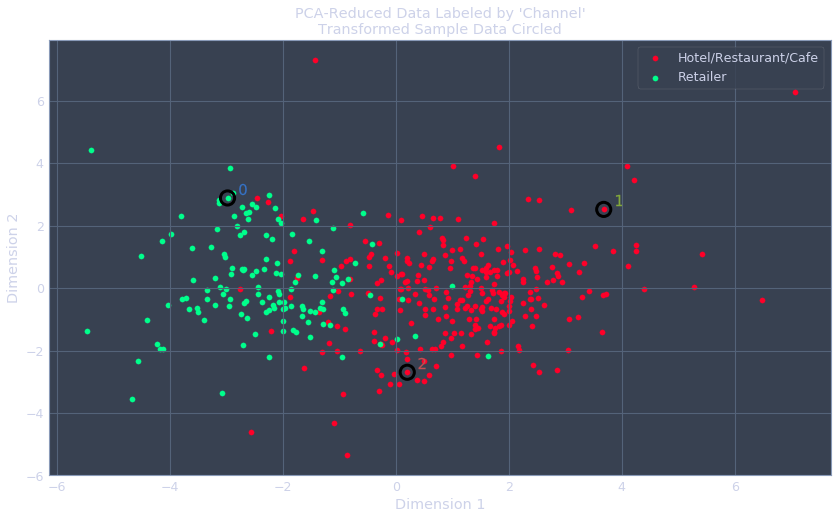

In [170]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

The clustering algorithm did a really good job at identifying the underlying distribution of data, if we look at the centers of the clusters we can roughly guess the establishments that could represent those clusters, which then will be consistent with real customers('Channel')

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.